In [1]:
gene_familly = "AP2"

In [2]:
# Parameters
gene_familly = "DBB"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA, DNA_MPI
from visualization import VISU, VISUReport
from feature_selection import SelectKFeature

[MacBook-Pro-de-Genereux.local:52278] shmem: mmap: an error occurred while determining whether or not /var/folders/w8/b_cflrn97k9c15rcrn5t8mmr0000gn/T//ompi.MacBook-Pro-de-Genereux.501/jf.0/2418540544/sm_segment.MacBook-Pro-de-Genereux.501.90280000.0 could be created.


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE
gene_info_path = "../data/gene_info_small.json"
trainset_path  = "../data/mix_data/trainset/"
testset_path   = "../data/mix_data/testset/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

# FOCUS ON GENE FAMALLY
gene_dict = gene_info[gene_familly]
df_path = trainset_path+gene_dict['file_code']+".csv"
ts_path = testset_path+gene_dict['file_code']+".csv"

#LOAD DF
USE_FULL_DF = True
if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
else:
    dataset_ = pd.read_csv(df_path)
    testset = pd.read_csv(ts_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)

In [6]:
dataset.head()

,Unnamed: 0,id,sequence,length,class
0,276,Carubv10010113m,MKIQCDVCEKAPATVICCADEAALCPNCDIEIHAANKLASKHQRLH...,248,1
1,238,Csa05g029840.1,MKIQCDVCEKAPATLICCADEAALCARCDVEIHAANKLASKHQRLF...,243,1
2,1402,Sopim07g062160.0.1,MKIQCNVCEVAEANVLCCADEAALCWSCDEKVHAANKLASKHQRVP...,299,1
3,1390,Sopen02g029130.1,MRTLCDVCESAAAILFCAADEAALCRACDEKVHMCNKLASRHVRVG...,182,1
4,867,GSMUA_Achr6P21590_001,MKIQCNACEAAEAAVLCCADEAALCWACDEKVHAANRLAGKHQRVP...,300,1


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2620 non-null   int64 
 1   id          2620 non-null   object
 2   sequence    2620 non-null   object
 3   length      2620 non-null   int64 
 4   class       2620 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 102.5+ KB


In [8]:
#sns.set(style="whitegrid")
#sns.violinplot(x=dataset.length)
#plt.title("sequence length distribution in test sequences")
#plt.show()

In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model-ft/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
21**2

441

In [12]:
k        = 2
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=200, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [13]:
X_train, y_train, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,AA,AC,AD,AF,AL,AM,AN,AP,AQ,AR,...,YE,YG,YH,YI,YL,YP,YR,YS,YV,YY
0,0.006135,0.000000,0.006135,0.004090,0.004090,0.002045,0.006135,0.014315,0.002045,0.006135,...,0.000000,0.004090,0.002045,0.0,0.002045,0.000000,0.0,0.000000,0.0,0.000000
1,0.010067,0.003356,0.003356,0.000000,0.006711,0.000000,0.006711,0.003356,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.006711,0.000000,0.0,0.003356,0.0,0.000000
2,0.002778,0.000000,0.002778,0.002778,0.000000,0.000000,0.005556,0.002778,0.002778,0.005556,...,0.002778,0.002778,0.000000,0.0,0.000000,0.005556,0.0,0.002778,0.0,0.002778
3,0.008299,0.000000,0.004149,0.000000,0.004149,0.000000,0.008299,0.000000,0.000000,0.012448,...,0.000000,0.000000,0.000000,0.0,0.004149,0.000000,0.0,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.004032,0.000000,0.000000,0.004032,0.004032,0.000000,0.008065,...,0.000000,0.000000,0.000000,0.0,0.000000,0.004032,0.0,0.004032,0.0,0.004032


In [14]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2620, 200)
X_test: (656, 200)
y_train: (2620,)
y_test: (656,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [15]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,721 (370.00 KB)

 Trainable params: 94,721 (370.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 22s 691ms/step - accuracy: 0.5000 - loss: 0.6928

31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6813 - loss: 0.6690   

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6946 - loss: 0.6635 - val_accuracy: 0.9637 - val_loss: 0.3672


Epoch 2/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.3528

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9638 - loss: 0.2389 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9644 - loss: 0.2334 - val_accuracy: 0.9733 - val_loss: 0.0857


Epoch 3/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0324

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0464 - val_accuracy: 0.9733 - val_loss: 0.1085


Epoch 4/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0489

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0370 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0371 - val_accuracy: 0.9828 - val_loss: 0.0740


Epoch 5/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0325

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0358 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0357 - val_accuracy: 0.9790 - val_loss: 0.0684


Epoch 6/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0083

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0245 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0247 - val_accuracy: 0.9828 - val_loss: 0.0664


Epoch 7/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0093

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0238 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9950 - loss: 0.0236 - val_accuracy: 0.9866 - val_loss: 0.0529


Epoch 8/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.2267

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0410 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0397 - val_accuracy: 0.9866 - val_loss: 0.0592


Epoch 9/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0315

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0179 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0178 - val_accuracy: 0.9847 - val_loss: 0.0602


Epoch 10/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.1309

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0379 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0369 - val_accuracy: 0.9885 - val_loss: 0.0476


Epoch 11/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0027

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0123 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0124 - val_accuracy: 0.9790 - val_loss: 0.0887


Epoch 12/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0308

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0118 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0119 - val_accuracy: 0.9866 - val_loss: 0.0628


Epoch 13/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0227

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0115 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0115 - val_accuracy: 0.9905 - val_loss: 0.0448


Epoch 14/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0019

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0134 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0133 - val_accuracy: 0.9847 - val_loss: 0.0614


Epoch 15/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0041

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0086 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0089 - val_accuracy: 0.9905 - val_loss: 0.0499


Epoch 16/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 7.7773e-04

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0090     

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0091 - val_accuracy: 0.9847 - val_loss: 0.0660


Epoch 17/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0032

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0140 - val_accuracy: 0.9828 - val_loss: 0.0781


Epoch 18/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0311

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0102 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0101 - val_accuracy: 0.9885 - val_loss: 0.0572


Epoch 19/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0070

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0169 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0168 - val_accuracy: 0.9905 - val_loss: 0.0441


Epoch 20/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0021

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0092 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0094 - val_accuracy: 0.9905 - val_loss: 0.0424


Epoch 21/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0065

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0100 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0100 - val_accuracy: 0.9866 - val_loss: 0.0652


Epoch 22/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0024

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0066 - val_accuracy: 0.9866 - val_loss: 0.0622


Epoch 23/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0058

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0040 - val_accuracy: 0.9905 - val_loss: 0.0500



[Train Accuracy: 99.95% - Test Accuracy: 98.93%]


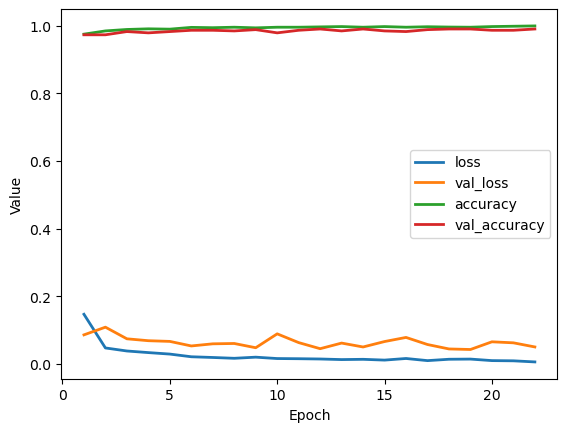

In [16]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [17]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [18]:
21**3

9261

In [19]:
k        = 3
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['rf', 0.1])

In [20]:
X_train, y_train, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test.head()

,NKL,KLA,DRA,ANK,LFC,CDI,RFL,EAA,IQC,CDV,...,GWG,MVA,YAS,EVQ,HYS,KGL,HLQ,LAC,GQL,LSV
0,0.000000,0.002049,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.002049,0.0,0.0,0.0,0.002049
1,0.003367,0.003367,0.003367,0.0,0.003367,0.003367,0.0,0.003367,0.003367,0.003367,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.002786,0.002786,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.004049


In [21]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2620, 1000)
X_test: (656, 1000)
y_train: (2620,)
y_test: (656,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,521 (1.14 MB)

 Trainable params: 299,521 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 23s 738ms/step - accuracy: 0.6094 - loss: 0.6931

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6442 - loss: 0.6891   

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7396 - loss: 0.6716 - val_accuracy: 0.9618 - val_loss: 0.3942


Epoch 2/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.3975

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9693 - loss: 0.2854 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9730 - loss: 0.2405 - val_accuracy: 0.9828 - val_loss: 0.0481


Epoch 3/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0323

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - loss: 0.0497 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9911 - loss: 0.0429 - val_accuracy: 0.9943 - val_loss: 0.0286


Epoch 4/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9688 - loss: 0.0962

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9920 - loss: 0.0289 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9939 - loss: 0.0228 - val_accuracy: 0.9962 - val_loss: 0.0289


Epoch 5/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0022

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0031 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0039 - val_accuracy: 0.9924 - val_loss: 0.0405


Epoch 6/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9844 - loss: 0.0438

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0165 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0145 - val_accuracy: 0.9962 - val_loss: 0.0302


Epoch 7/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 5.8892e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0108     

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.0096 - val_accuracy: 0.9924 - val_loss: 0.0333


Epoch 8/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0083

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0055 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0058 - val_accuracy: 0.9962 - val_loss: 0.0304


Epoch 9/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.4918e-04

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0049     

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0065 - val_accuracy: 0.9924 - val_loss: 0.0442


Epoch 10/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0061

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0058 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0056 - val_accuracy: 0.9943 - val_loss: 0.0324


Epoch 11/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.7612e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.7562e-04 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9924 - val_loss: 0.0350


Epoch 12/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0015

21/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0029 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0031 - val_accuracy: 0.9962 - val_loss: 0.0313


Epoch 13/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 2.8767e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0030     

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0033 - val_accuracy: 0.9924 - val_loss: 0.0325


Epoch 14/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.2155e-04

20/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 8.8167e-04 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9924 - val_loss: 0.0346



[Train Accuracy: 99.95% - Test Accuracy: 99.09%]


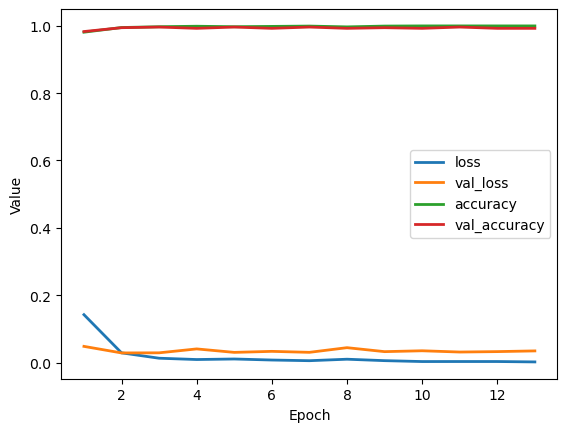

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [25]:
21**4

194481

In [26]:
k        = 4
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=size, discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.1])

In [27]:
X_train, y_train, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAI,AADE,AAEA,AAEI,AAEV,AAFI,AAIL,AAIV,AALC,AANK,...,YLLF,YLLL,YLME,YLRP,YLTK,YRGV,YVSG,YWKA,YWPK,YYRC
0,0.0,0.002053,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.003378,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [29]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,473 (1.13 MB)

 Trainable params: 297,473 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 18s 563ms/step - accuracy: 0.5156 - loss: 0.6932

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6603 - loss: 0.6832   

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7073 - loss: 0.6710 - val_accuracy: 0.9275 - val_loss: 0.4281


Epoch 2/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9062 - loss: 0.4352

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9383 - loss: 0.3227 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9406 - loss: 0.2983 - val_accuracy: 0.9637 - val_loss: 0.1013


Epoch 3/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0931

25/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9645 - loss: 0.1000 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9646 - loss: 0.1000 - val_accuracy: 0.9752 - val_loss: 0.0614


Epoch 4/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0572

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9762 - loss: 0.0752 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9768 - loss: 0.0739 - val_accuracy: 0.9885 - val_loss: 0.0379


Epoch 5/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0567

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0616 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9815 - loss: 0.0602 - val_accuracy: 0.9885 - val_loss: 0.0307


Epoch 6/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0719

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - loss: 0.0472 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9840 - loss: 0.0483 - val_accuracy: 0.9924 - val_loss: 0.0266


Epoch 7/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0224

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0441 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9868 - loss: 0.0447 - val_accuracy: 0.9962 - val_loss: 0.0251


Epoch 8/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0784

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0430 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.0400 - val_accuracy: 0.9962 - val_loss: 0.0218


Epoch 9/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0552

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0329 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0331 - val_accuracy: 0.9962 - val_loss: 0.0162


Epoch 10/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0054

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0339 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0320 - val_accuracy: 0.9962 - val_loss: 0.0158


Epoch 11/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0152

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0289 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9915 - loss: 0.0286 - val_accuracy: 0.9924 - val_loss: 0.0214


Epoch 12/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0216

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0269 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9916 - loss: 0.0275 - val_accuracy: 0.9962 - val_loss: 0.0272


Epoch 13/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.1329

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0392 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0349 - val_accuracy: 0.9962 - val_loss: 0.0160


Epoch 14/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0264

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0194 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9967 - loss: 0.0203 - val_accuracy: 0.9962 - val_loss: 0.0134


Epoch 15/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0036

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0155 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0179 - val_accuracy: 0.9962 - val_loss: 0.0139


Epoch 16/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0078

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0113 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9956 - loss: 0.0136 - val_accuracy: 0.9962 - val_loss: 0.0121


Epoch 17/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0016

24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0177 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9956 - loss: 0.0183 - val_accuracy: 0.9981 - val_loss: 0.0131


Epoch 18/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0028

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0184 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9943 - loss: 0.0183 - val_accuracy: 0.9962 - val_loss: 0.0143


Epoch 19/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0076

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0142 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9964 - loss: 0.0151 - val_accuracy: 0.9981 - val_loss: 0.0120


Epoch 20/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0019

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0147 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9952 - loss: 0.0145 - val_accuracy: 0.9962 - val_loss: 0.0138


Epoch 21/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0129

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0211 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9950 - loss: 0.0225 - val_accuracy: 0.9962 - val_loss: 0.0184


Epoch 22/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 7.0563e-04

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0145     

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9958 - loss: 0.0164 - val_accuracy: 0.9962 - val_loss: 0.0133


Epoch 23/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0047

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0232 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9940 - loss: 0.0217 - val_accuracy: 0.9981 - val_loss: 0.0125


Epoch 24/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0108

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0207 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0193 - val_accuracy: 0.9962 - val_loss: 0.0117


Epoch 25/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0106

23/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0065 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0085 - val_accuracy: 0.9981 - val_loss: 0.0120


Epoch 26/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0813

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0199 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0176 - val_accuracy: 0.9981 - val_loss: 0.0112


Epoch 27/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0033

22/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0140 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.0143 - val_accuracy: 0.9962 - val_loss: 0.0115



[Train Accuracy: 99.52% - Test Accuracy: 98.93%]


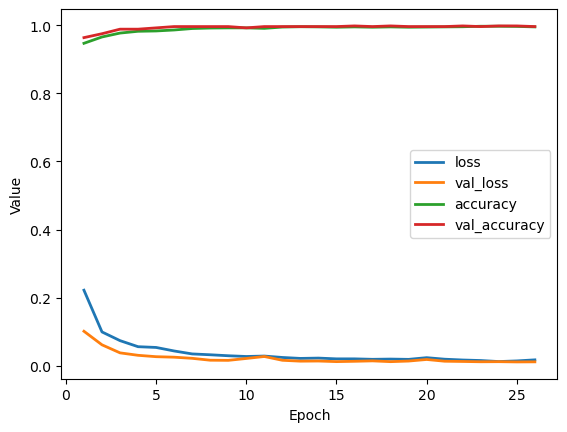

In [30]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step


In [32]:
#report.save()

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [33]:
21**5

4084101

In [34]:
k        = 5
size     = int(len(dataset))
selector = SelectKFeature(dataset, k_feature=1000, kmer_size=k, domaine=domaine, sample_size=min(1300/len(dataset), 1), discriminative=None)
mask     = selector.get_feature_mask(method=['f_test', 0.00001]);

In [35]:
k = 5
X_train, y_train, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
X_test, y_test, _ = DNA.build_kmer_representation_v2(testset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False, feature_mask=mask)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AAAEV,AAAIL,AAAIV,AADEA,AAEAA,AAEAK,AAEAR,AAEIR,AAEVP,AAFIF,...,YLIET,YLLLR,YLLTG,YLMET,YLRPD,YLTKT,YRGVR,YSDDD,YVSGH,YWKAT
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00339,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [37]:
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 586,497 (2.24 MB)

 Trainable params: 586,497 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 18s 593ms/step - accuracy: 0.5781 - loss: 0.6932

16/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5307 - loss: 0.6906   

32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5377 - loss: 0.6816

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5423 - loss: 0.6797 - val_accuracy: 0.9676 - val_loss: 0.5158


Epoch 2/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.5078

18/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9458 - loss: 0.4563 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9489 - loss: 0.4057 - val_accuracy: 0.9313 - val_loss: 0.1706


Epoch 3/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9062 - loss: 0.2308

17/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9511 - loss: 0.1499 

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9525 - loss: 0.1445

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9525 - loss: 0.1443 - val_accuracy: 0.9523 - val_loss: 0.1246


Epoch 4/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0300

16/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9715 - loss: 0.0912 

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9682 - loss: 0.0989

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9679 - loss: 0.0994 - val_accuracy: 0.9695 - val_loss: 0.0887


Epoch 5/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9531 - loss: 0.1218

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9641 - loss: 0.0883 

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9665 - loss: 0.0828

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9671 - loss: 0.0820 - val_accuracy: 0.9714 - val_loss: 0.0661


Epoch 6/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0377

14/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9798 - loss: 0.0598 

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9795 - loss: 0.0631

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9798 - loss: 0.0630 - val_accuracy: 0.9695 - val_loss: 0.0826


Epoch 7/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9219 - loss: 0.1980

14/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9648 - loss: 0.1022 

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9698 - loss: 0.0893

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9718 - loss: 0.0844 - val_accuracy: 0.9752 - val_loss: 0.0542


Epoch 8/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0621

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9811 - loss: 0.0674 

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9816 - loss: 0.0641

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9820 - loss: 0.0627 - val_accuracy: 0.9790 - val_loss: 0.0480


Epoch 9/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0312

14/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9900 - loss: 0.0332 

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9897 - loss: 0.0374

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9896 - loss: 0.0384 - val_accuracy: 0.9885 - val_loss: 0.0438


Epoch 10/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0514

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9903 - loss: 0.0384 

30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9899 - loss: 0.0388

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9899 - loss: 0.0391 - val_accuracy: 0.9885 - val_loss: 0.0415


Epoch 11/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0134

13/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9937 - loss: 0.0329 

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0328

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9919 - loss: 0.0351 - val_accuracy: 0.9790 - val_loss: 0.0485


Epoch 12/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.1013

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9867 - loss: 0.0521 

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9885 - loss: 0.0468

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9887 - loss: 0.0459 - val_accuracy: 0.9924 - val_loss: 0.0380


Epoch 13/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0416

14/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9940 - loss: 0.0246 

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0323

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9924 - loss: 0.0333 - val_accuracy: 0.9771 - val_loss: 0.0617


Epoch 14/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0031

12/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9946 - loss: 0.0210 

26/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9939 - loss: 0.0266

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9936 - loss: 0.0280 - val_accuracy: 0.9905 - val_loss: 0.0381


Epoch 15/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0071

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - loss: 0.0229 

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9936 - loss: 0.0274

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9933 - loss: 0.0285 - val_accuracy: 0.9866 - val_loss: 0.0413


Epoch 16/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.0415

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9857 - loss: 0.0468 

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9871 - loss: 0.0462

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9874 - loss: 0.0459 - val_accuracy: 0.9866 - val_loss: 0.0435


Epoch 17/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0312

14/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0283 

28/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9942 - loss: 0.0267

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9943 - loss: 0.0266 - val_accuracy: 0.9790 - val_loss: 0.0647


Epoch 18/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9844 - loss: 0.0171

14/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9896 - loss: 0.0263 

27/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9915 - loss: 0.0261

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9919 - loss: 0.0266 - val_accuracy: 0.9924 - val_loss: 0.0331


Epoch 19/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0121

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0407 

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9926 - loss: 0.0362

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9925 - loss: 0.0357 - val_accuracy: 0.9771 - val_loss: 0.0674


Epoch 20/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0028

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9928 - loss: 0.0266 

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0296

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9933 - loss: 0.0300 - val_accuracy: 0.9905 - val_loss: 0.0368


Epoch 21/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0511

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9934 - loss: 0.0259 

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9944 - loss: 0.0237

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9945 - loss: 0.0239 - val_accuracy: 0.9866 - val_loss: 0.0419


Epoch 22/100


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0068

15/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9964 - loss: 0.0220 

29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9960 - loss: 0.0223

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9958 - loss: 0.0225 - val_accuracy: 0.9924 - val_loss: 0.0316



[Train Accuracy: 99.52% - Test Accuracy: 99.09%]


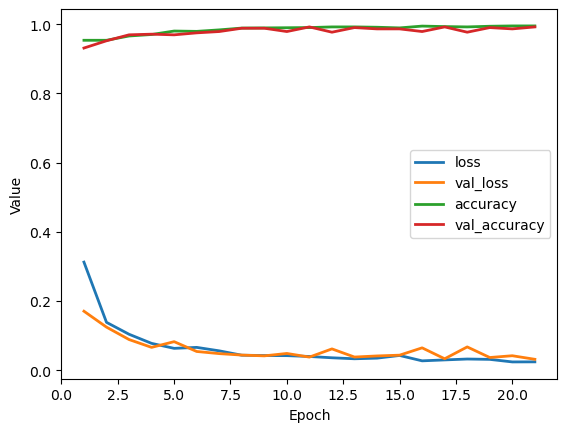

In [38]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [39]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('-ft')

 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step


Report saved as Output/Reports/DBB/report_full_AVZZXEVU.html


In [40]:
# END

In [41]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################